In [50]:
from matplotlib import pyplot as plt
from matplotlib import image as pmimage
import numpy as np
from scipy import io
from random import shuffle

Problem 1

PCA and low dimensional PCA

In [51]:
data_path = '../material/face.mat'
face_mat = io.loadmat(data_path)
X = np.array(face_mat['X'])
L = np.array(face_mat['l']).ravel()
total_num = np.shape(X)[1]
train_idx = np.array(range(total_num)) % 10 < 8
test_idx = np.array(range(total_num)) % 10 > 8
shuffle(train_idx)
train_num = total_num * 8 // 10
test_num = total_num - train_num
train_X = X[:, train_idx]
train_L = L[train_idx]
test_X = X[:, test_idx]
test_L = L[test_idx]

In [52]:
def pca(normed_features):
    S = normed_features @ normed_features.transpose() /np.shape(normed_features)[1]
    return np.linalg.eig(S)

def low_pca(normed_features):
    S = normed_features.transpose() @ normed_features / np.shape(normed_features)[1]
    val, vec = np.linalg.eig(S)
    vec = normed_features @ vec
    vec = vec / np.sqrt(np.sum(np.power(vec, 2), axis=0))
    return val, vec

In [53]:
mean_feat = np.mean(train_X, axis=1)
A = train_X - mean_feat[:, None]
val_1, u1 = pca(A)
val_2, u2 = low_pca(A)

original nonzero eig_val is 415
 reduced eig_val is 415


C:\Users\wyong\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


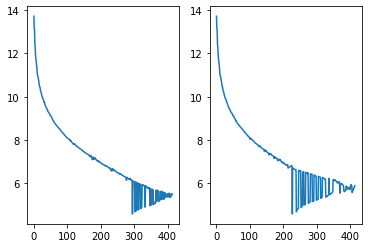

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.log(val_1[val_1 > 1]))
ax2.plot(np.log(val_2[val_2 > 1]))
print("original nonzero eig_val is {}\n reduced eig_val is {}".format(
    np.count_nonzero(val_1 > 1), np.count_nonzero(val_2 > 1)
))

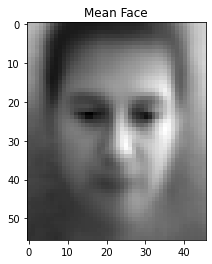

In [55]:
mean_face = mean_feat.reshape((-1, 56)).transpose()
plt.imshow(mean_face, cmap='gray')
plt.title('Mean Face');

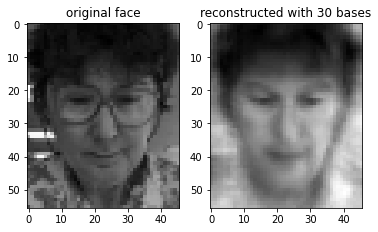

In [56]:
n = 30
sample = test_X[:, 0]
a = (sample - mean_feat) @ u2[:, :n]
recon = mean_feat + np.sum(u2[:, :n] * a, axis=1)
recon_fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(sample.reshape((-1, 56)).transpose(), cmap='gray')
ax2.imshow(recon.reshape((-1, 56)).transpose(), cmap='gray')
ax1.set_title('original face')
ax2.set_title('reconstructed with {} bases'.format(n));

Problem 2

Face recognition with PCA and PCA-LDA

In [57]:
from sklearn.neighbors import KNeighborsClassifier

classification with pca

In [58]:
m = 20
pcaed_train = u2[:, :m].transpose() @ (train_X - mean_feat[:, None])
clf = KNeighborsClassifier()
clf.fit(pcaed_train.transpose(), train_L.ravel())
pcaed_test = u2[:, :m].transpose() @ (test_X - mean_feat[:, None])
predict_batch_pca = clf.predict(pcaed_test.transpose())
print("accuracy of pca is {}".format(np.count_nonzero(predict_batch_pca == test_L) / (test_num)))

accuracy of pca is 0.3076923076923077


classification with pca-lda

In [59]:
def lda(feats, labels):
    mean_per_class = np.array([np.mean(feats[:, labels == i], axis=1) for i in range(1, num_class + 1)])
    scatter_b = np.zeros((mpca, mpca))
    scatter_w = np.zeros((mpca, mpca))
    for i in range(1, num_class + 1):
        temp = mean_per_class[i - 1] - mean_pca_pcalda
        scatter_b += np.count_nonzero(train_L == i) * temp[:, None] @ temp.reshape((1, -1))
    for i in range(train_num):
        temp = pca_train_pcalda[:, i] - mean_per_class[train_L[i] - 1]
        scatter_w += temp[:, None] @ temp.reshape((1, -1))
    return np.linalg.eig(np.linalg.inv(scatter_w) @ scatter_b)


In [60]:
mpca = 20
mlda = 10
num_class = 52
pca_train_pcalda = u2[:, :mpca].transpose() @ (train_X - mean_feat[:, None])
mean_pca_pcalda = np.mean(pca_train_pcalda, axis=1)
pca_test_pcalda = u2[:, :mpca].transpose() @ (test_X - mean_feat[:, None])
lda_val, lda_vec = lda(pca_train_pcalda, train_L)
pca_lda_train = lda_vec[:, :mlda].transpose() @ (pca_train_pcalda - mean_pca_pcalda[:, None])
clf_pca_lda = KNeighborsClassifier()
clf_pca_lda.fit(pca_lda_train.transpose(), train_L)
pca_lda_test = lda_vec[:, :mlda].transpose() @ (pca_test_pcalda - np.mean(pca_test_pcalda, axis=1)[:, None])
predict_pca_lda = clf_pca_lda.predict(pca_lda_test.transpose())
print("accuracy of pca-lda is {}".format(np.count_nonzero(predict_pca_lda == test_L) / test_num))

accuracy of pca-lda is 0.40384615384615385


Problem 3

Incremental PCA

In [61]:
train_subset1 = train_X[:, 0::4]
train_subset2 = train_X[:, 1::4]
train_subset3 = train_X[:, 2::4]
train_subset4 = train_X[:, 3::4]
